<a href="https://colab.research.google.com/github/KimGriezmann/DeepLearning_BeTheLegend/blob/master/working_whalepig/data_EDA_and_Prediction_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [2]:
data_2018 = pd.read_csv("/content/data_2018.csv", encoding='euc-kr')
hitter_2018 = pd.read_csv("/content/batter_data_2018.csv", encoding='euc-kr')

data_2019 = pd.read_csv("/content/data_2019.csv", encoding='euc-kr')
hitter_2019 = pd.read_csv("/content/batter_data_2019.csv", encoding='euc-kr')

data_2020 = pd.read_csv("/content/data_2020.csv", encoding='euc-kr')
hitter_2020 = pd.read_csv("/content/batter_data_2020.csv", encoding='euc-kr')

data_2021 = pd.read_csv("/content/data_2021.csv", encoding='euc-kr')
hitter_2021 = pd.read_csv("/content/batter_data_2021.csv", encoding='euc-kr')

## 날짜 값, 형식 변경

In [3]:
# 날짜 데이터 값, 형식 변경
# 현재 : object 형식으로 "2018-04-04" 값으로 존재 (의미 : 4월 4일)
# 변경 : int 형식으로 20180404 으로 변경 (의미 : 2018년 4월 4일)

def day_to_int(data):
  data['day'] = pd.to_numeric(data['day'].str.replace("-",""))
  return data

In [4]:
# 날짜 데이터 문장열 형식의 값에서 -> 정수형식의 값으로 변경
data_2018 = day_to_int(data_2018)
data_2019 = day_to_int(data_2019)
data_2020 = day_to_int(data_2020)
data_2021 = day_to_int(data_2021)

## 더블헤더 생성 함수

In [5]:
def make_double(data):
  # 더블헤더 처리
  temp = np.zeros(len(data), dtype=np.int8)

  # day, name이 같은 값이 있다는 것은 더블헤더 경기가 있다는것
  # keep=False 옵션은 중복 값에 해당하는 튜플들을 모두 True로 리턴, 그 외 옵션 : 'first', 'last' 의 경우 둘 중 하나만 True
  dup = data.loc[:,['day','name']].duplicated(keep=False) 

  for i in range(len(data)):
    if dup[i]==False:
      temp[i]=0
    elif dup[i]==True:
      temp[i]=1

  # 중복의 첫번째 행은 더블헤더 1차전
  # 중복인 두번째 행이 더블헤더 2차전이다.
  for i in range(1,len(temp)):
    if temp[i]==1 and temp[i-1]==1:
      temp[i]=2

  data['double']=temp
  return data

In [6]:
data_2018 = make_double(data_2018)
data_2019 = make_double(data_2019)
data_2020 = make_double(data_2020)
data_2021 = make_double(data_2021)

## 최근 5일 타율


In [7]:
# 선수마다 최근 5일의 타율을 구해야함. 
# 현재 day에서 -5부터 -1까지의 sum(hit)/sum(ab) 값을 구하면 된다

# hitter_data : 90명 타자 data
# record_data : 날짜별 타자 기록
# recent_day : 기본(최근 5일), 설정 가능
def make_recent_days(hitter_data, record_data, day=5):

  # 최근 5일(기본) 타율 저장할 공간 생성
  recent_days_avg = np.zeros(len(record_data)) # 최근 5일(기본) 경기 타율
  recent_days_hitter = np.empty(len(record_data), dtype=np.chararray) # type : 문자열 저장을 위해 chararray
  recent_days_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  recent_days_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata['day'])): # 추출한 데이터에서 한 행씩 접근
      recent_days_hitter[ps] = h # 현재 타자
      r = hdata.loc[i,'day']  # 현재 기준 날짜
      recent_days_day[ps] = r
      d = hdata.loc[i,'double'] # 현재 더블헤더 분류
      recent_days_double[ps] = d
      if d==2: # 더블헤더 2차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r].loc[hdata['double']!=2] # r 날짜까지 가져와서 2차전을 제외
      else: # 더블헤더가 아니고, 더블헤더 1차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r-1] # 접근한 행의 날짜를 기준으로 5일(기본) 경기

      if len(hrdata)==0: # 최근 5일 경기 없으면 넘어가고
        ps+=1
        continue
      else : # 있으면
        sum_ab = sum(hrdata['ab'])
        if sum_ab==0: # 경기 기록은 존재하지만 타수(ab)가 0
          ps+=1
          continue
        sum_hit = sum(hrdata['hit'])
        recent_days_avg[ps] = sum_hit/sum_ab
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = recent_days_day
  result_Dataframe['name'] = recent_days_hitter
  result_Dataframe['recent_'+str(day)+'days_avg'] = recent_days_avg
  result_Dataframe['double'] = recent_days_double

  return result_Dataframe

In [8]:
recent_5days_data_2018 = make_recent_days(hitter_2018, data_2018, day=5)
recent_5days_data_2019 = make_recent_days(hitter_2019, data_2019, day=5)
recent_5days_data_2020 = make_recent_days(hitter_2020, data_2020, day=5)
recent_5days_data_2021 = make_recent_days(hitter_2021, data_2021, day=5)

100%|██████████| 90/90 [00:11<00:00,  8.16it/s]


## 최근 5경기 타율


In [9]:
# 최근 5경기 타율
# 최근 5경기 타율은 2018년 4월 11일 기준이라면 4월 6일부터 4월 10일까지의 데이터를 통해 얻는다.
# 최근 5경기 타율은 경기를 기준으로 만든다.
# 주의) 최근 5일 경기 타율과 헷갈리지 않게 주의

def make_recent_games(hitter_data, record_data, game=5):

  # 최근 5경기(기본) 타율 저장할 공간 생성
  recent_games_avg = np.zeros(len(record_data)) # 최근 5경기(기본) 경기 타율
  recent_games_hitter = np.empty(len(record_data), dtype=np.chararray) # type : 문자열 저장을 위해 chararray
  recent_games_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  recent_games_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata)): # 추출한 데이터에서 한 행씩 접근
      recent_games_hitter[ps] = h # 현재 타자
      recent_games_day[ps] = hdata.loc[i,'day'] # 현재 경기
      recent_games_double[ps] = hdata.loc[i,'double'] # 현재 더블헤더 분류
      hrdata = hdata.loc[i-game:i-1,:] # 접근한 행의 경기를 기준으로 5경기
         
      if len(hrdata)==0: # 최근 5경기가 없으면 (첫 경기)
        ps+=1
        continue
      else : # 있으면
        sum_ab = sum(hrdata['ab'])
        if sum_ab==0: # 경기 기록은 존재하지만 타수(ab)가 0
          ps+=1
          continue
        sum_hit = sum(hrdata['hit'])
        recent_games_avg[ps] = sum_hit/sum_ab
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = recent_games_day
  result_Dataframe['name'] = recent_games_hitter
  result_Dataframe['recent_'+str(game)+'games_avg'] = recent_games_avg
  result_Dataframe['double'] = recent_games_double

  return result_Dataframe

In [10]:
recent_5games_data_2018 = make_recent_games(hitter_2018, data_2018, game=5)
recent_5games_data_2019 = make_recent_games(hitter_2019, data_2019, game=5)
recent_5games_data_2020 = make_recent_games(hitter_2020, data_2020, game=5)
recent_5games_data_2021 = make_recent_games(hitter_2021, data_2021, game=5)

100%|██████████| 90/90 [00:01<00:00, 50.89it/s]


## 최근 10일 안타 성공률


In [11]:
# 최근 날짜를 기준으로 성공률을 구할 때는 더블헤더를 신경 써주어야한다.

def make_success_days(hitter_data, record_data, day=10):

  # 최근 10일(기본) 안타 성공률 저장할 공간 생성
  success_days = np.zeros(len(record_data)) # 최근 10일(기본) 안타 성공률
  success_days_hitter = np.empty(len(record_data), dtype=object) # type : 문자열 저장을 위해 object
  success_days_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  success_days_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata['day'])): # 추출한 데이터에서 한 행씩 접근
      success_days_hitter[ps] = h # 현재 타자
      r = hdata.loc[i,'day']  # 현재 기준 날짜
      success_days_day[ps] = r
      d = hdata.loc[i,'double'] # 현재 더블헤더 분류
      success_days_double[ps] = d
      if d==2: # 더블헤더 2차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r].loc[hdata['double']!=2] # r 날짜까지 가져와서 2차전을 제외
      else: # 더블헤더가 아니고, 더블헤더 1차전이라면
        hrdata = hdata.loc[hdata['day']>=r-day].loc[hdata['day']<=r-1] # 접근한 행의 날짜를 기준으로 10일(기본) 경기
         
      if len(hrdata)==0: # 최근 10일(기본) 경기 없으면 넘어가고
        ps+=1
        continue
      else : # 있으면
        total = len(hrdata)
        fail = len(hrdata.loc[hrdata['hit']==0]) # 안타를 못친 경기가 몇경기나 되는지 저장
        success_days[ps] = (total-fail)/total
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = success_days_day
  result_Dataframe['name'] = success_days_hitter
  result_Dataframe['success_'+str(day)+'days'] = success_days
  result_Dataframe['double'] = success_days_double

  return result_Dataframe

In [12]:
success_10days_data_2018 = make_success_days(hitter_2018, data_2018, day=10)
success_10days_data_2019 = make_success_days(hitter_2019, data_2019, day=10)
success_10days_data_2020 = make_success_days(hitter_2020, data_2020, day=10)
success_10days_data_2021 = make_success_days(hitter_2021, data_2021, day=10)

100%|██████████| 90/90 [00:13<00:00,  6.68it/s]


## 최근 10경기 안타 성공률


In [13]:
def make_success_games(hitter_data, record_data, game=10):

  # 최근 10경기(기본) 안타 성공률 저장할 공간 생성
  success_games = np.zeros(len(record_data)) # 최근 10경기(기본) 안타 성공률
  success_games_hitter = np.empty(len(record_data), dtype=object) # type : 문자열 저장을 위해 object
  success_games_day = np.empty(len(record_data), dtype=np.int32) # 기준이 되는 날짜
  success_games_double = np.zeros(len(record_data), dtype=np.int8) # 더블헤더 분류 / 0 : 더블헤더 아님 / 1 : 더블헤더 1차전 / 2 : 더블헤더 2차전

  ps = 0
  for h in tqdm.tqdm(hitter_data['name']): # 90명 타자 한명씩 접근
    hdata = record_data.loc[record_data['name']==h].reset_index() # 특정 타자 한명에 대해서만 데이터 추출
    for i in range(len(hdata)): # 추출한 데이터에서 한 행씩 접근
      success_games_hitter[ps] = h # 현재 타자
      success_games_day[ps] = hdata.loc[i,'day'] # 현재 경기
      success_games_double[ps] = hdata.loc[i,'double'] # 현재 더블헤더 분류

      hrdata = hdata.loc[i-game:i-1,:] # 접근한 행의 경기를 기준으로 10경기(기본)
         
      if len(hrdata)==0: # 최근 10경기(기본)가 없으면 (첫 경기)
        ps+=1
        continue
      else : # 있으면
        total = len(hrdata)
        fail = len(hrdata.loc[hrdata['hit']==0]) # 안타를 못친 경기가 몇경기나 되는지 저장
        success_games[ps] = (total-fail)/total
        ps+=1

  result_Dataframe = pd.DataFrame()
  result_Dataframe['day'] = success_games_day
  result_Dataframe['name'] = success_games_hitter
  result_Dataframe['success_'+str(game)+'games'] = success_games
  result_Dataframe['double'] = success_games_double

  return result_Dataframe

In [14]:
success_10games_data_2018 = make_success_games(hitter_2018, data_2018, game=10)
success_10games_data_2019 = make_success_games(hitter_2019, data_2019, game=10)
success_10games_data_2020 = make_success_games(hitter_2020, data_2020, game=10)
success_10games_data_2021 = make_success_games(hitter_2021, data_2021, game=10)

100%|██████████| 90/90 [00:06<00:00, 13.96it/s]


## 해당 경기의 안타 성공 결과(result) 도출


In [15]:
data_2018['result'] = [0 if s == 0 else 1 for s in data_2018['hit']] 
data_2019['result'] = [0 if s == 0 else 1 for s in data_2019['hit']] 
data_2020['result'] = [0 if s == 0 else 1 for s in data_2020['hit']] 
data_2021['result'] = [0 if s == 0 else 1 for s in data_2021['hit']] 

## 위에서 생성한 자료들과 데이터 merge

In [16]:
data_2018 = pd.merge(data_2018, recent_5days_data_2018, on = ['name', 'day', 'double'])
data_2019 = pd.merge(data_2019, recent_5days_data_2019, on = ['name', 'day', 'double'])
data_2020 = pd.merge(data_2020, recent_5days_data_2020, on = ['name', 'day', 'double'])
data_2021 = pd.merge(data_2021, recent_5days_data_2021, on = ['name', 'day', 'double'])

data_2018 = pd.merge(data_2018, recent_5games_data_2018, on = ['name', 'day', 'double'])
data_2019 = pd.merge(data_2019, recent_5games_data_2019, on = ['name', 'day', 'double'])
data_2020 = pd.merge(data_2020, recent_5games_data_2020, on = ['name', 'day', 'double'])
data_2021 = pd.merge(data_2021, recent_5games_data_2021, on = ['name', 'day', 'double'])

data_2018 = pd.merge(data_2018, success_10days_data_2018, on = ['name', 'day', 'double'])
data_2019 = pd.merge(data_2019, success_10days_data_2019, on = ['name', 'day', 'double'])
data_2020 = pd.merge(data_2020, success_10days_data_2020, on = ['name', 'day', 'double'])
data_2021 = pd.merge(data_2021, success_10days_data_2021, on = ['name', 'day', 'double'])

data_2018 = pd.merge(data_2018, success_10games_data_2018, on = ['name', 'day', 'double'])
data_2019 = pd.merge(data_2019, success_10games_data_2019, on = ['name', 'day', 'double'])
data_2020 = pd.merge(data_2020, success_10games_data_2020, on = ['name', 'day', 'double'])
data_2021 = pd.merge(data_2021, success_10games_data_2021, on = ['name', 'day', 'double'])


# Data EDA

In [49]:
data=pd.concat([data_2018,data_2019,data_2020,data_2021], ignore_index=True)
data.shape

(39118, 37)

In [35]:
print(data_2018.shape,data_2019.shape,data_2020.shape,data_2021.shape)
print(len(data_2018)+len(data_2019)+len(data_2020)+len(data_2021))

(11316, 37) (10994, 37) (10988, 37) (5820, 37)
39118


## 선발 선수만 가져옴 (교체 선수 제거)

In [57]:
data_2018 = data_2018.loc[data_2018['start_member']==1]
data_2019 = data_2019.loc[data_2019['start_member']==1]
data_2020 = data_2020.loc[data_2020['start_member']==1]
data_2021 = data_2021.loc[data_2021['start_member']==1]
data = data.loc[data['start_member']==1]

## 최근 5일 타율과 당일 경기 안타 성공과의 관계

In [ ]:
data_2018.loc[:,['name','day','double','recent_5days_avg','result']]

,name,day,double,recent_5days_avg,result
0,나성범,20180324,0.0,0.000000,0
1,나성범,20180325,0.0,0.000000,1
2,나성범,20180327,0.0,0.142857,1
3,나성범,20180328,0.0,0.272727,0
4,나성범,20180329,0.0,0.200000,1
...,...,...,...,...,...
11311,강경학,20181006,0.0,0.250000,0
11312,강경학,20181009,0.0,0.000000,1
11313,강경학,20181019,0.0,0.000000,0
11314,강경학,20181020,0.0,0.000000,0


### RAW DATA : scatter plot


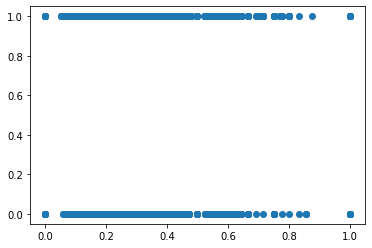

In [ ]:
plt.scatter(data_2018['recent_5days_avg'], data_2018['result'])

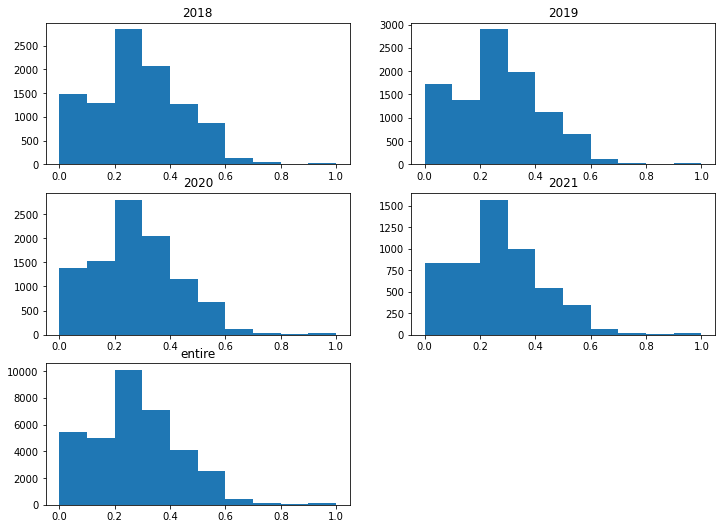

In [58]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
plt.hist(data_2018['recent_5days_avg'])
plt.title("2018")

plt.subplot(4, 2, 2)
plt.hist(data_2019['recent_5days_avg'])
plt.title("2019")

plt.subplot(4, 2, 3)
plt.hist(data_2020['recent_5days_avg'])
plt.title("2020")

plt.subplot(4, 2, 4)
plt.hist(data_2021['recent_5days_avg'])
plt.title("2021")

plt.subplot(4, 2, 5)
plt.hist(data['recent_5days_avg'])
plt.title("entire")

plt.show()

### 범위를 나누어서 개수로 파악해보자

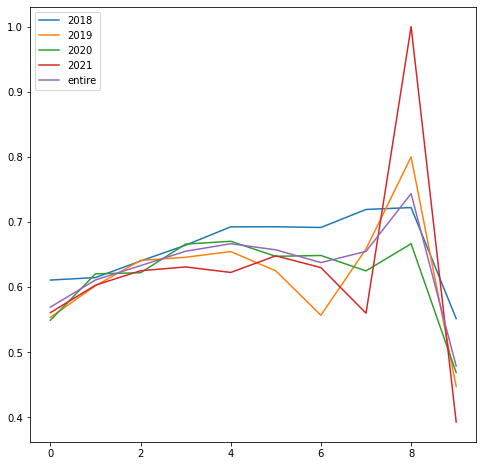

In [53]:
plt.figure(figsize=(8,8))

# 2018

output_tmp = np.zeros(10)

tmp = data_2018.loc[data_2018['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.2].loc[data_2018['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.3].loc[data_2018['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.4].loc[data_2018['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.5].loc[data_2018['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.6].loc[data_2018['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.7].loc[data_2018['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.8].loc[data_2018['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.9].loc[data_2018['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2018")


# 2019

tmp = data_2019.loc[data_2019['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.2].loc[data_2019['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.3].loc[data_2019['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.4].loc[data_2019['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.5].loc[data_2019['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.6].loc[data_2019['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.7].loc[data_2019['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.8].loc[data_2019['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.9].loc[data_2019['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2019")


# 2020

tmp = data_2020.loc[data_2020['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.2].loc[data_2020['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.3].loc[data_2020['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.4].loc[data_2020['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.5].loc[data_2020['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.6].loc[data_2020['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.7].loc[data_2020['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.8].loc[data_2020['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.9].loc[data_2020['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2020")


# 2021

tmp = data_2021.loc[data_2021['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.2].loc[data_2021['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.3].loc[data_2021['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.4].loc[data_2021['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.5].loc[data_2021['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.6].loc[data_2021['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.7].loc[data_2021['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.8].loc[data_2021['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.9].loc[data_2021['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2021")


# 2021

tmp = data.loc[data['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.2].loc[data['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.3].loc[data['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.4].loc[data['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.5].loc[data['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.6].loc[data['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.7].loc[data['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.8].loc[data['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.9].loc[data['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="entire")

plt.legend()
plt.show()

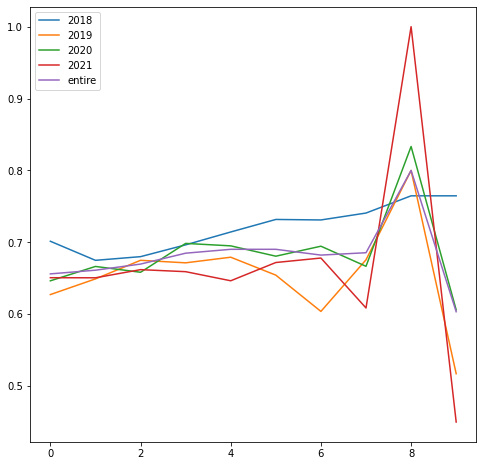

In [59]:
plt.figure(figsize=(8,8))

# 2018

output_tmp = np.zeros(10)

tmp = data_2018.loc[data_2018['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.2].loc[data_2018['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.3].loc[data_2018['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.4].loc[data_2018['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.5].loc[data_2018['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.6].loc[data_2018['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.7].loc[data_2018['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.8].loc[data_2018['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']<0.9].loc[data_2018['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2018")


# 2019

tmp = data_2019.loc[data_2019['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.2].loc[data_2019['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.3].loc[data_2019['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.4].loc[data_2019['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.5].loc[data_2019['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.6].loc[data_2019['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.7].loc[data_2019['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.8].loc[data_2019['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']<0.9].loc[data_2019['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2019")


# 2020

tmp = data_2020.loc[data_2020['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.2].loc[data_2020['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.3].loc[data_2020['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.4].loc[data_2020['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.5].loc[data_2020['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.6].loc[data_2020['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.7].loc[data_2020['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.8].loc[data_2020['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']<0.9].loc[data_2020['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2020")


# 2021

tmp = data_2021.loc[data_2021['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.2].loc[data_2021['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.3].loc[data_2021['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.4].loc[data_2021['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.5].loc[data_2021['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.6].loc[data_2021['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.7].loc[data_2021['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.8].loc[data_2021['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']<0.9].loc[data_2021['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2021")


# 2021

tmp = data.loc[data['recent_5days_avg']<0.1,['recent_5days_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.2].loc[data['recent_5days_avg']>=0.1,['recent_5days_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.3].loc[data['recent_5days_avg']>=0.2,['recent_5days_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.4].loc[data['recent_5days_avg']>=0.3,['recent_5days_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.5].loc[data['recent_5days_avg']>=0.4,['recent_5days_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.6].loc[data['recent_5days_avg']>=0.5,['recent_5days_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.7].loc[data['recent_5days_avg']>=0.6,['recent_5days_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.8].loc[data['recent_5days_avg']>=0.7,['recent_5days_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']<0.9].loc[data['recent_5days_avg']>=0.8,['recent_5days_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5days_avg']>=0.9,['recent_5days_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="entire")

plt.legend()
plt.show()

다른 년도에 대해서도 해보아야겠지만 최근 5일 타율이 좋을수록 해당 경기에서 안타를 치는 성공률이 높아지는 모습을 볼 수 있다.

## 최근 5경기 타율과 당일 경기 안타 성공과의 관계

### RAW DATA : scatter plot

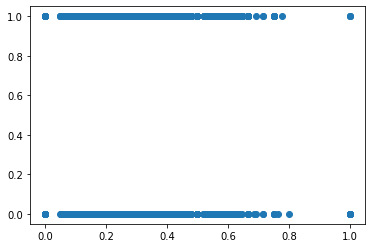

In [ ]:
plt.scatter(data_2018['recent_5games_avg'], data_2018['result'])

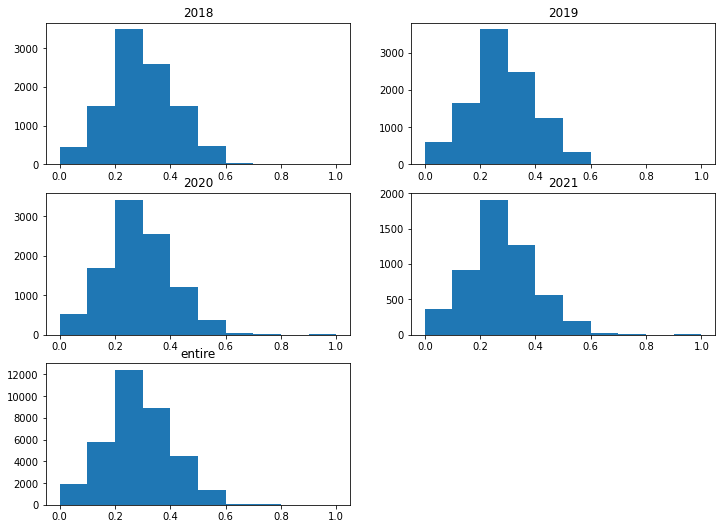

In [60]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
plt.hist(data_2018['recent_5games_avg'])
plt.title("2018")

plt.subplot(4, 2, 2)
plt.hist(data_2019['recent_5games_avg'])
plt.title("2019")

plt.subplot(4, 2, 3)
plt.hist(data_2020['recent_5games_avg'])
plt.title("2020")

plt.subplot(4, 2, 4)
plt.hist(data_2021['recent_5games_avg'])
plt.title("2021")

plt.subplot(4, 2, 5)
plt.hist(data['recent_5games_avg'])
plt.title("entire")

plt.show()

### 범위를 나누어서 개수로 파악해보자

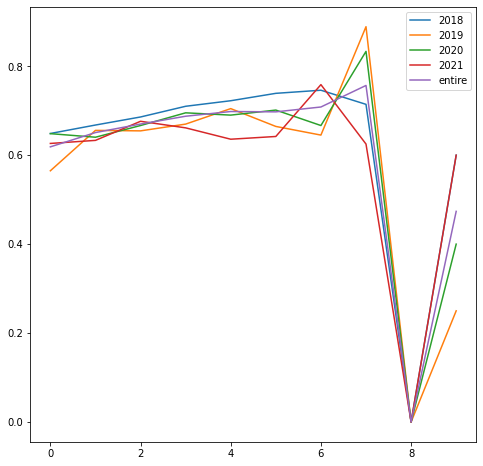

In [67]:
plt.figure(figsize=(8,8))

# 2018

output_tmp = np.zeros(10)

tmp = data_2018.loc[data_2018['recent_5games_avg']<0.1,['recent_5games_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.2].loc[data_2018['recent_5games_avg']>=0.1,['recent_5games_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.3].loc[data_2018['recent_5games_avg']>=0.2,['recent_5games_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.4].loc[data_2018['recent_5games_avg']>=0.3,['recent_5games_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.5].loc[data_2018['recent_5games_avg']>=0.4,['recent_5games_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.6].loc[data_2018['recent_5games_avg']>=0.5,['recent_5games_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.7].loc[data_2018['recent_5games_avg']>=0.6,['recent_5games_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.8].loc[data_2018['recent_5games_avg']>=0.7,['recent_5games_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['recent_5games_avg']<0.9].loc[data_2018['recent_5games_avg']>=0.8,['recent_5games_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/(len(tmp)+0.01)
tmp = data_2018.loc[data_2018['recent_5games_avg']>=0.9,['recent_5games_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2018")


# 2019

tmp = data_2019.loc[data_2019['recent_5games_avg']<0.1,['recent_5games_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.2].loc[data_2019['recent_5games_avg']>=0.1,['recent_5games_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.3].loc[data_2019['recent_5games_avg']>=0.2,['recent_5games_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.4].loc[data_2019['recent_5games_avg']>=0.3,['recent_5games_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.5].loc[data_2019['recent_5games_avg']>=0.4,['recent_5games_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.6].loc[data_2019['recent_5games_avg']>=0.5,['recent_5games_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.7].loc[data_2019['recent_5games_avg']>=0.6,['recent_5games_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.8].loc[data_2019['recent_5games_avg']>=0.7,['recent_5games_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2019.loc[data_2019['recent_5games_avg']<0.9].loc[data_2019['recent_5games_avg']>=0.8,['recent_5games_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/(len(tmp)+0.01)
tmp = data_2019.loc[data_2019['recent_5games_avg']>=0.9,['recent_5games_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2019")


# 2020

tmp = data_2020.loc[data_2020['recent_5games_avg']<0.1,['recent_5games_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.2].loc[data_2020['recent_5games_avg']>=0.1,['recent_5games_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.3].loc[data_2020['recent_5games_avg']>=0.2,['recent_5games_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.4].loc[data_2020['recent_5games_avg']>=0.3,['recent_5games_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.5].loc[data_2020['recent_5games_avg']>=0.4,['recent_5games_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.6].loc[data_2020['recent_5games_avg']>=0.5,['recent_5games_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.7].loc[data_2020['recent_5games_avg']>=0.6,['recent_5games_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.8].loc[data_2020['recent_5games_avg']>=0.7,['recent_5games_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2020.loc[data_2020['recent_5games_avg']<0.9].loc[data_2020['recent_5games_avg']>=0.8,['recent_5games_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/(len(tmp)+0.01)
tmp = data_2020.loc[data_2020['recent_5games_avg']>=0.9,['recent_5games_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2020")


# 2021

tmp = data_2021.loc[data_2021['recent_5games_avg']<0.1,['recent_5games_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.2].loc[data_2021['recent_5games_avg']>=0.1,['recent_5games_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.3].loc[data_2021['recent_5games_avg']>=0.2,['recent_5games_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.4].loc[data_2021['recent_5games_avg']>=0.3,['recent_5games_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.5].loc[data_2021['recent_5games_avg']>=0.4,['recent_5games_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.6].loc[data_2021['recent_5games_avg']>=0.5,['recent_5games_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.7].loc[data_2021['recent_5games_avg']>=0.6,['recent_5games_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.8].loc[data_2021['recent_5games_avg']>=0.7,['recent_5games_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2021.loc[data_2021['recent_5games_avg']<0.9].loc[data_2021['recent_5games_avg']>=0.8,['recent_5games_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/(len(tmp)+0.01)
tmp = data_2021.loc[data_2021['recent_5games_avg']>=0.9,['recent_5games_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="2021")


# 2021

tmp = data.loc[data['recent_5games_avg']<0.1,['recent_5games_avg', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.2].loc[data['recent_5games_avg']>=0.1,['recent_5games_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.3].loc[data['recent_5games_avg']>=0.2,['recent_5games_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.4].loc[data['recent_5games_avg']>=0.3,['recent_5games_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.5].loc[data['recent_5games_avg']>=0.4,['recent_5games_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.6].loc[data['recent_5games_avg']>=0.5,['recent_5games_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.7].loc[data['recent_5games_avg']>=0.6,['recent_5games_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.8].loc[data['recent_5games_avg']>=0.7,['recent_5games_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data.loc[data['recent_5games_avg']<0.9].loc[data['recent_5games_avg']>=0.8,['recent_5games_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/(len(tmp)+0.01)
tmp = data.loc[data['recent_5games_avg']>=0.9,['recent_5games_avg', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp, label="entire")

plt.legend()
plt.show()

위 그래프는 우상향하는 모습을 보이지 않는다.

## 최근 10일 안타 성공률과 당일 경기 안타 성공과의 관계

## avLI, RE24, WPA와 당일 경기 안타 성공과의 관계

### RAW DATA : scatter plot

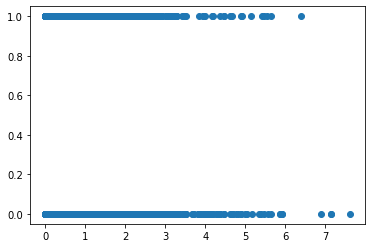

In [19]:
plt.scatter(data_2018['avLI'], data_2018['result'])

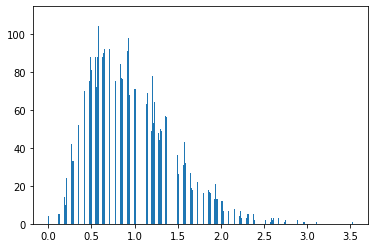

In [70]:
plt.hist(data_2018['avLI'],bins=1000)
plt.show()

(0.0, 6.0)

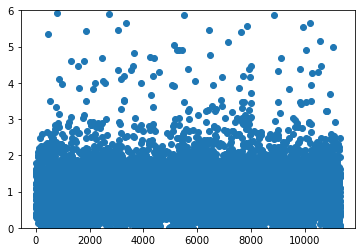

In [29]:
plt.hist(data_2018['avLI'])
plt.scatter(range(len(data_2018)),data_2018['avLI'])
plt.ylim(0,6)

plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
plt.hist(data_2018['avLI'],bins=100)
plt.title("2018")

plt.subplot(4, 2, 2)
plt.hist(data_2019['recent_5games_avg'])
plt.title("2019")

plt.subplot(4, 2, 3)
plt.hist(data_2020['recent_5games_avg'])
plt.title("2020")

plt.subplot(4, 2, 4)
plt.hist(data_2021['recent_5games_avg'])
plt.title("2021")

plt.subplot(4, 2, 5)
plt.hist(data['recent_5games_avg'])
plt.title("entire")

plt.show()

### 범위를 나누어서 개수로 파악해보자

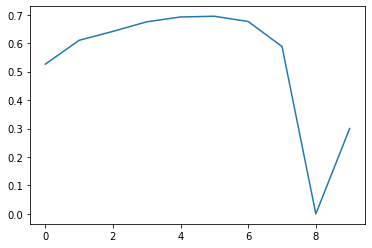

In [ ]:
output_tmp = np.zeros(10)

tmp = data_2018.loc[data_2018['avLI']<0.1,['avLI', 'result']]
output_tmp[0] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.2].loc[data_2018['avLI']>=0.1,['recent_5games_avg', 'result']]
output_tmp[1] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.3].loc[data_2018['avLI']>=0.2,['recent_5games_avg', 'result']]
output_tmp[2] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.4].loc[data_2018['avLI']>=0.3,['recent_5games_avg', 'result']]
output_tmp[3] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.5].loc[data_2018['avLI']>=0.4,['recent_5games_avg', 'result']]
output_tmp[4] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.6].loc[data_2018['avLI']>=0.5,['recent_5games_avg', 'result']]
output_tmp[5] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.7].loc[data_2018['avLI']>=0.6,['recent_5games_avg', 'result']]
output_tmp[6] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.8].loc[data_2018['avLI']>=0.7,['recent_5games_avg', 'result']]
output_tmp[7] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']<0.9].loc[data_2018['avLI']>=0.8,['recent_5games_avg', 'result']]
output_tmp[8] = sum(tmp['result'])/len(tmp)
tmp = data_2018.loc[data_2018['avLI']>=0.9,['avLI', 'result']]
output_tmp[9] = sum(tmp['result'])/len(tmp)

plt.plot(output_tmp)

# MLP 모델 구축, 학습, 예측

# 만들어보고 싶은 모델

RNN 구조로 인풋은 당일 타율이나, 타격 지표들을 넣는다.

그럼 이제 3일, 5일 전의 기록들이 오늘 경기에 미치는 영향의 가중치를 학습한다.

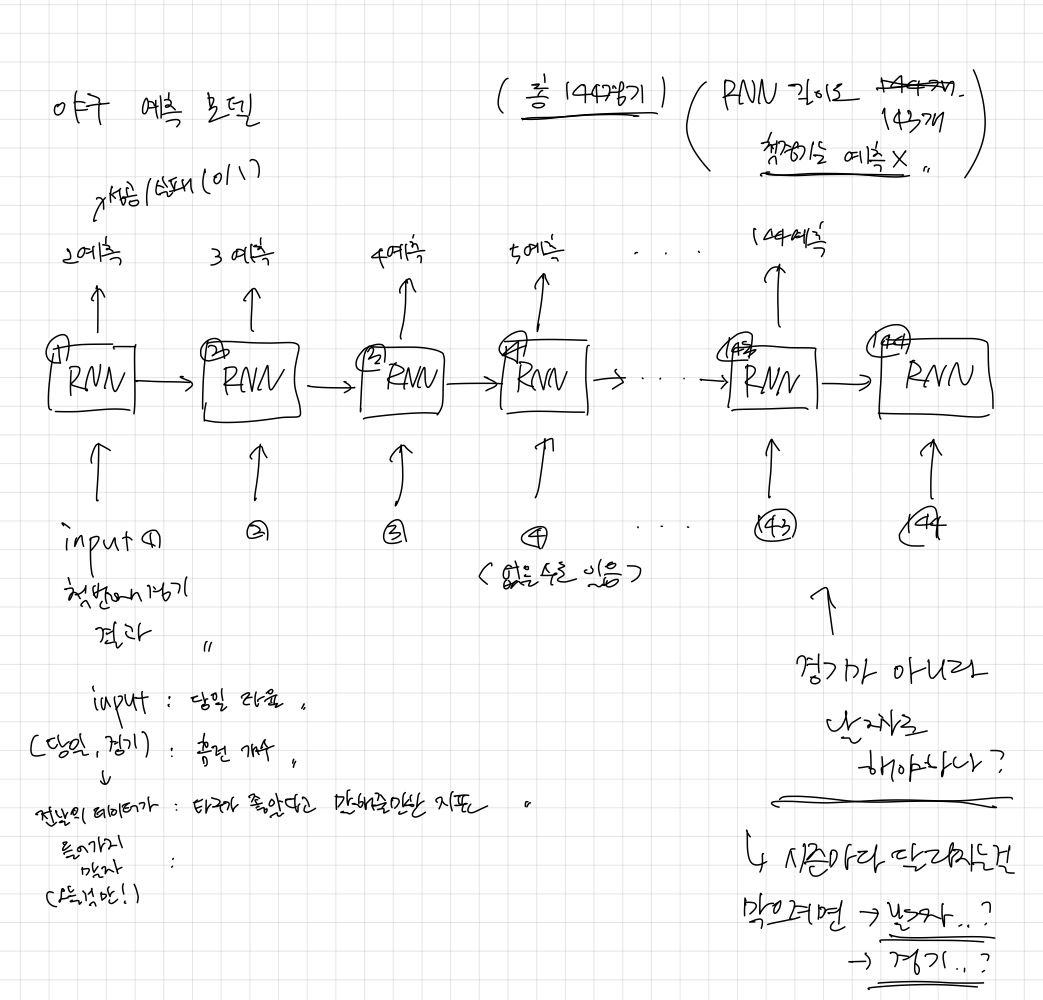